In [41]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd

sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/utils')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/models')

from utils.analysis import *
from utils.getters import * 
from utils.plotters import * 
from utils.helpers import * 
from utils.config import * 
from models_config.model_config_GSP import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reproducibility

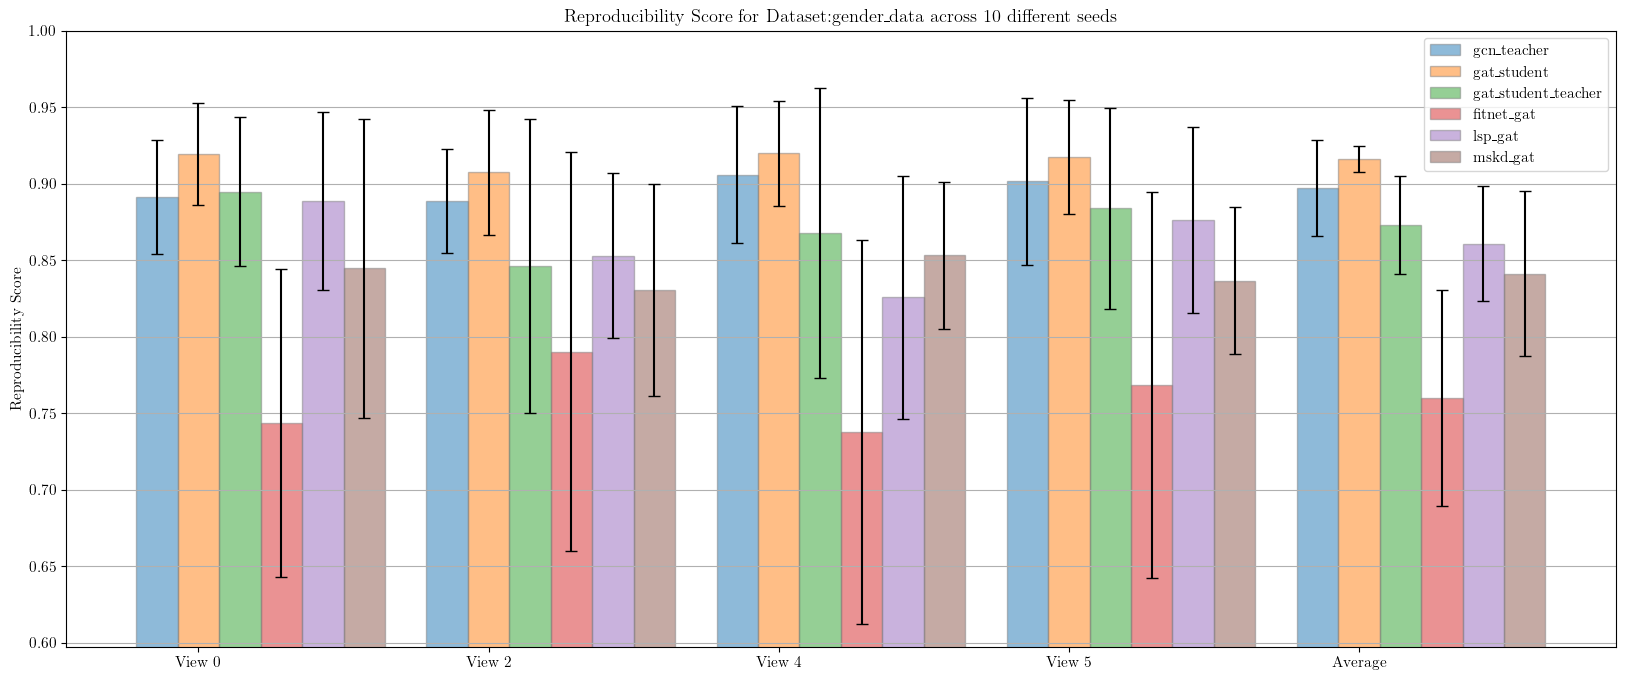

<Figure size 2000x800 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt

plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {
    'text.usetex' : True,
    'font.size' : 11,
    'font.family' :'lmodern'
}
plt.rcParams.update(params)

dataset="gender_data"
views=[0, 2, 4, 5]
models=["gcn", "gat_student", "gat_student_teacher", "fitnet_gat", "lsp_gat", "mskd_gat"]
model_args = [gcn_args, gat_gat_student_args, gcn_gat_student_args, gcn_gat_fitnet_student_args, gcn_gat_lsp_student_args, gcn_gat_mskd_student_args]
CV=["3Fold", "5Fold", "10Fold"]
runs=[i for i in range(10)]
save_fig=False

plot_bar_chart_reproducibility_mulitple_runs(dataset, views, models, CV, runs, students=[-1,-1,-1,-1,-1,-1], model_args=model_args, save_fig=False)

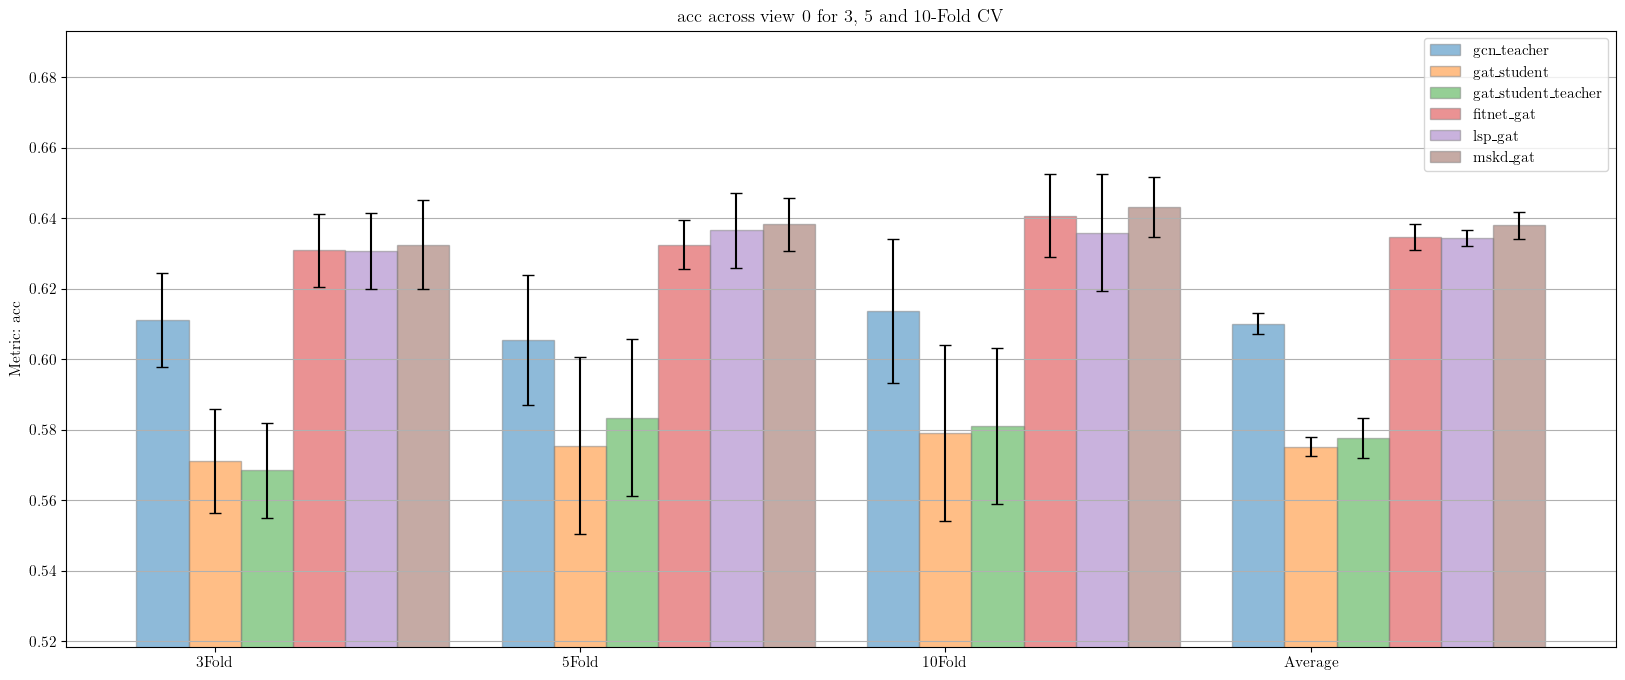

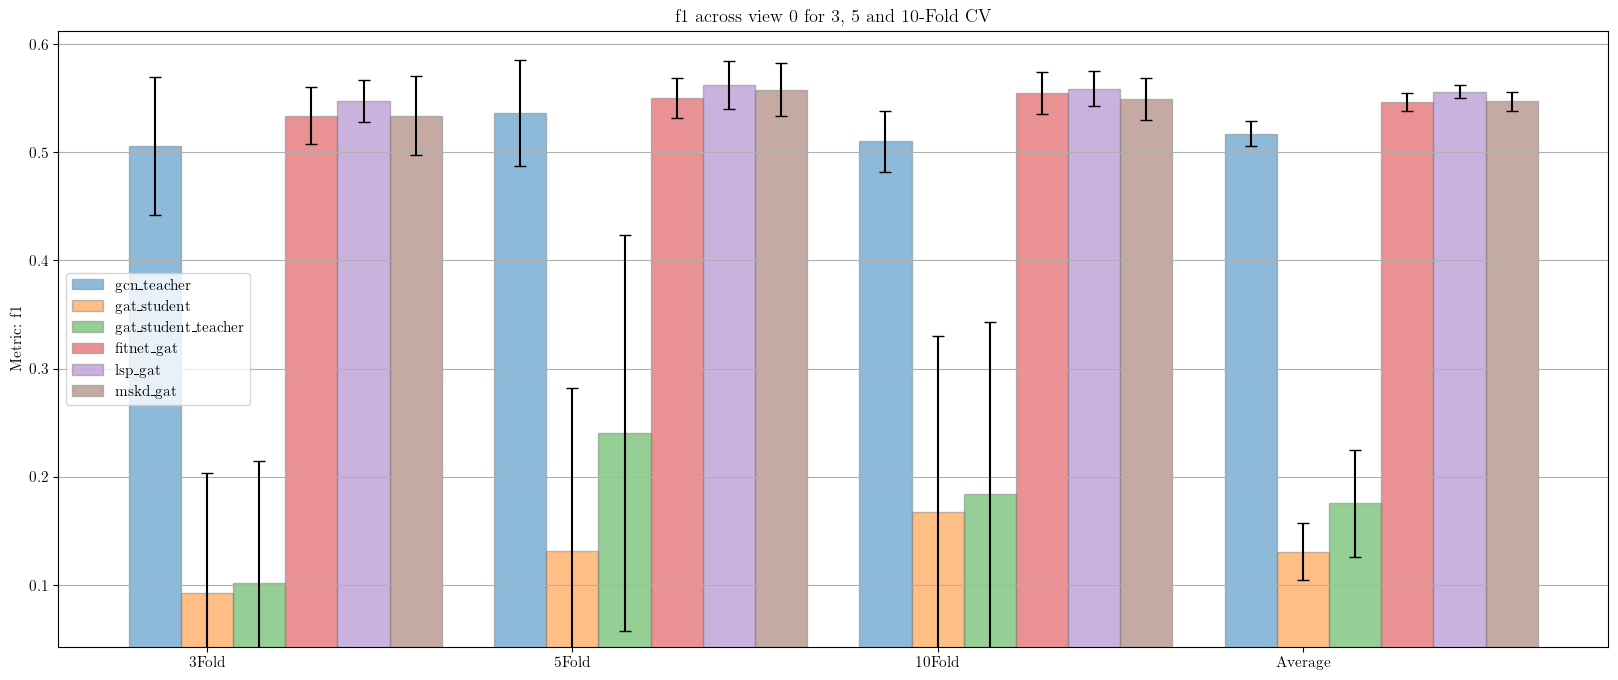

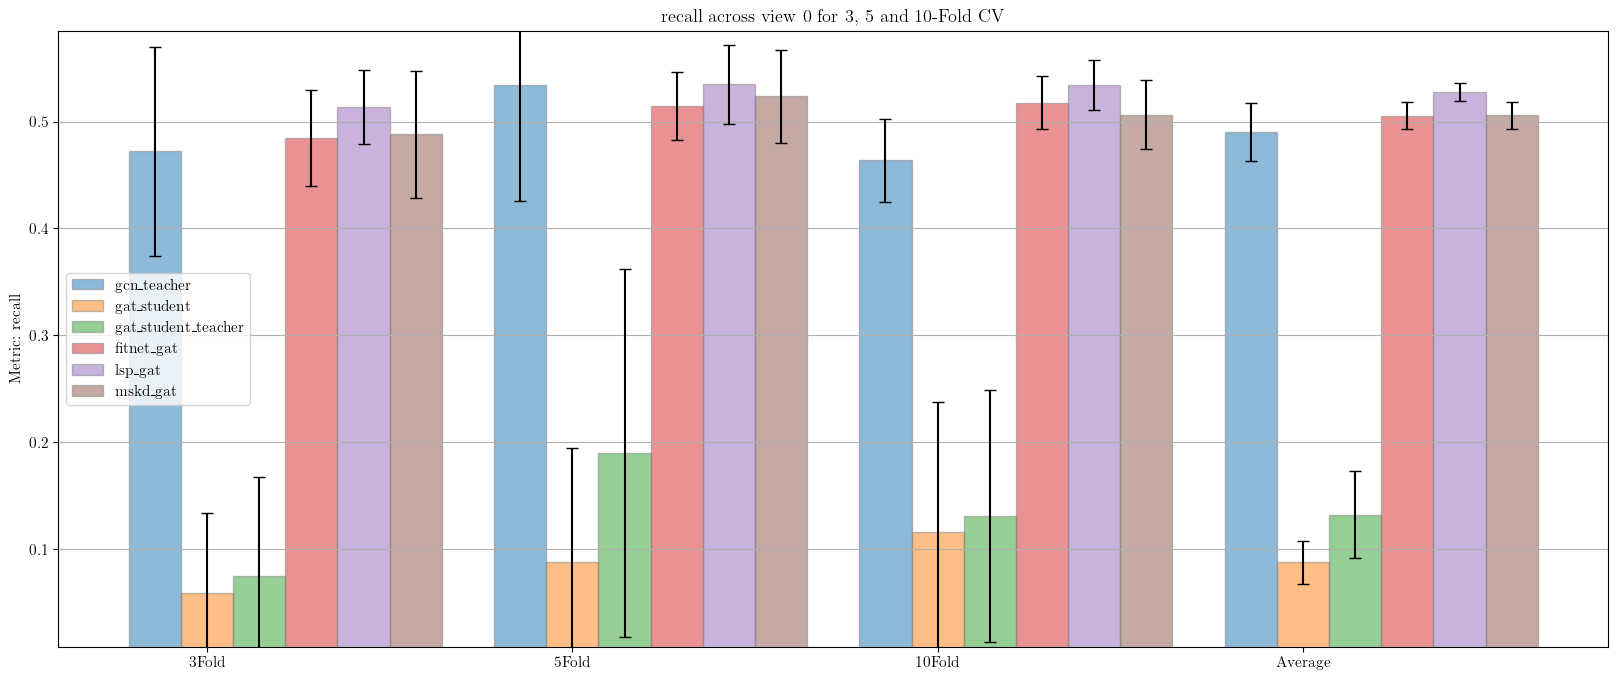

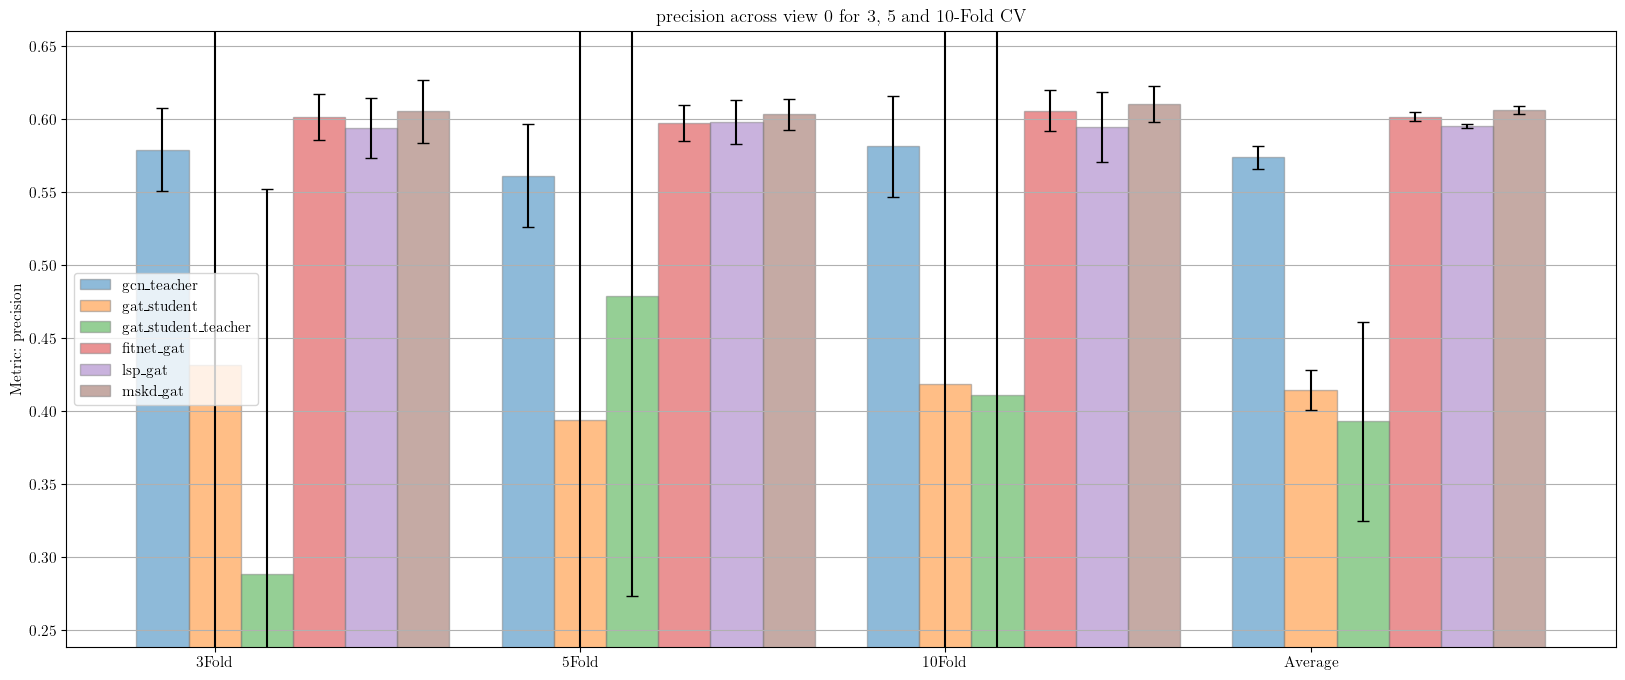

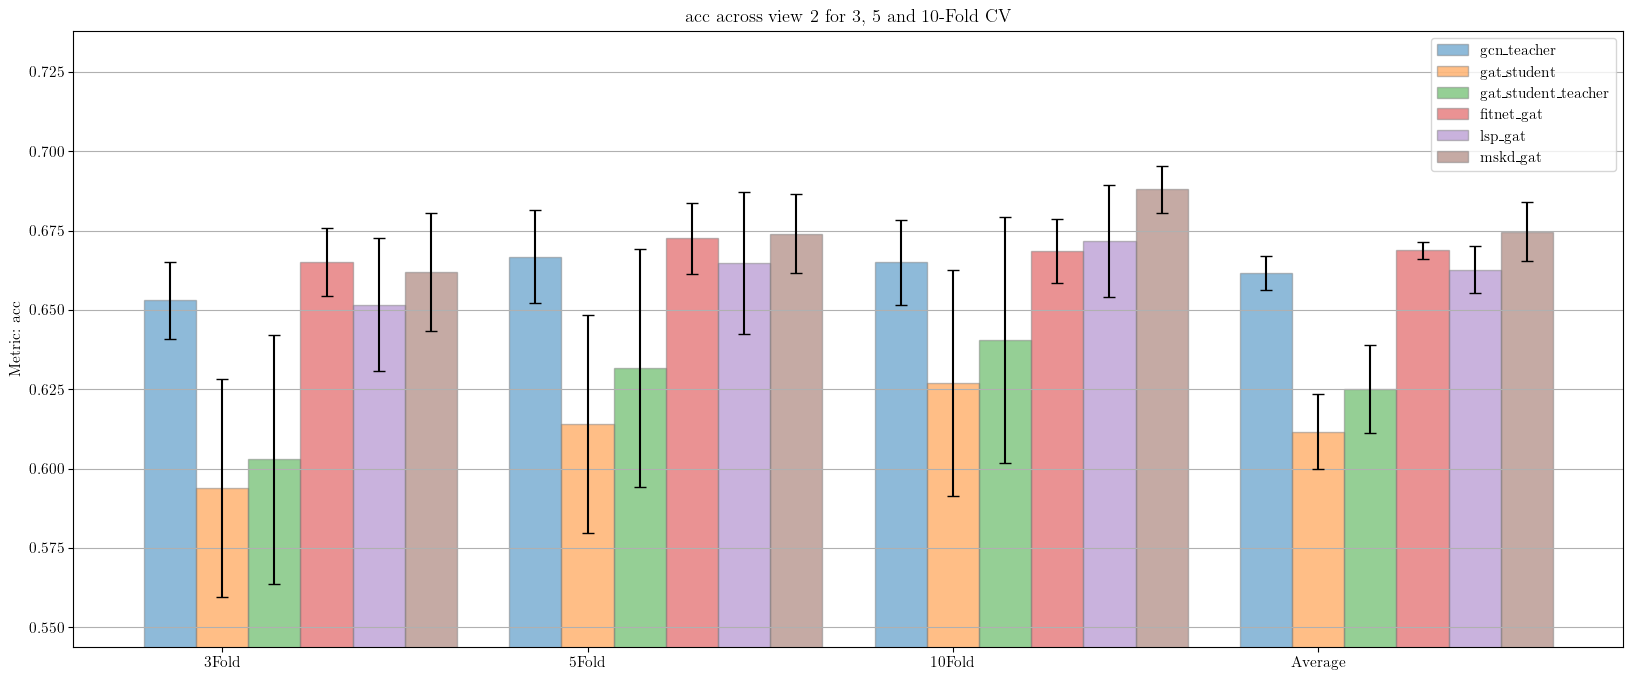

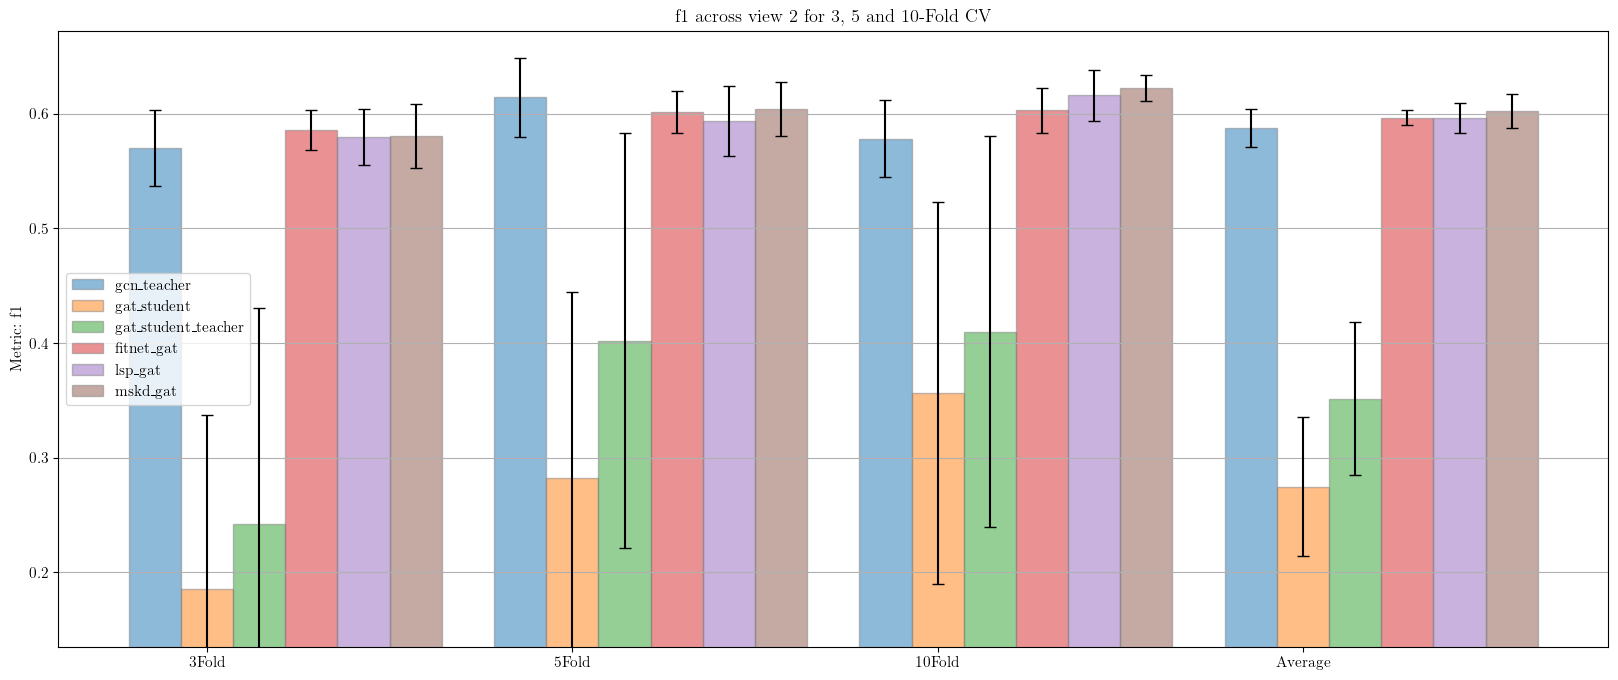

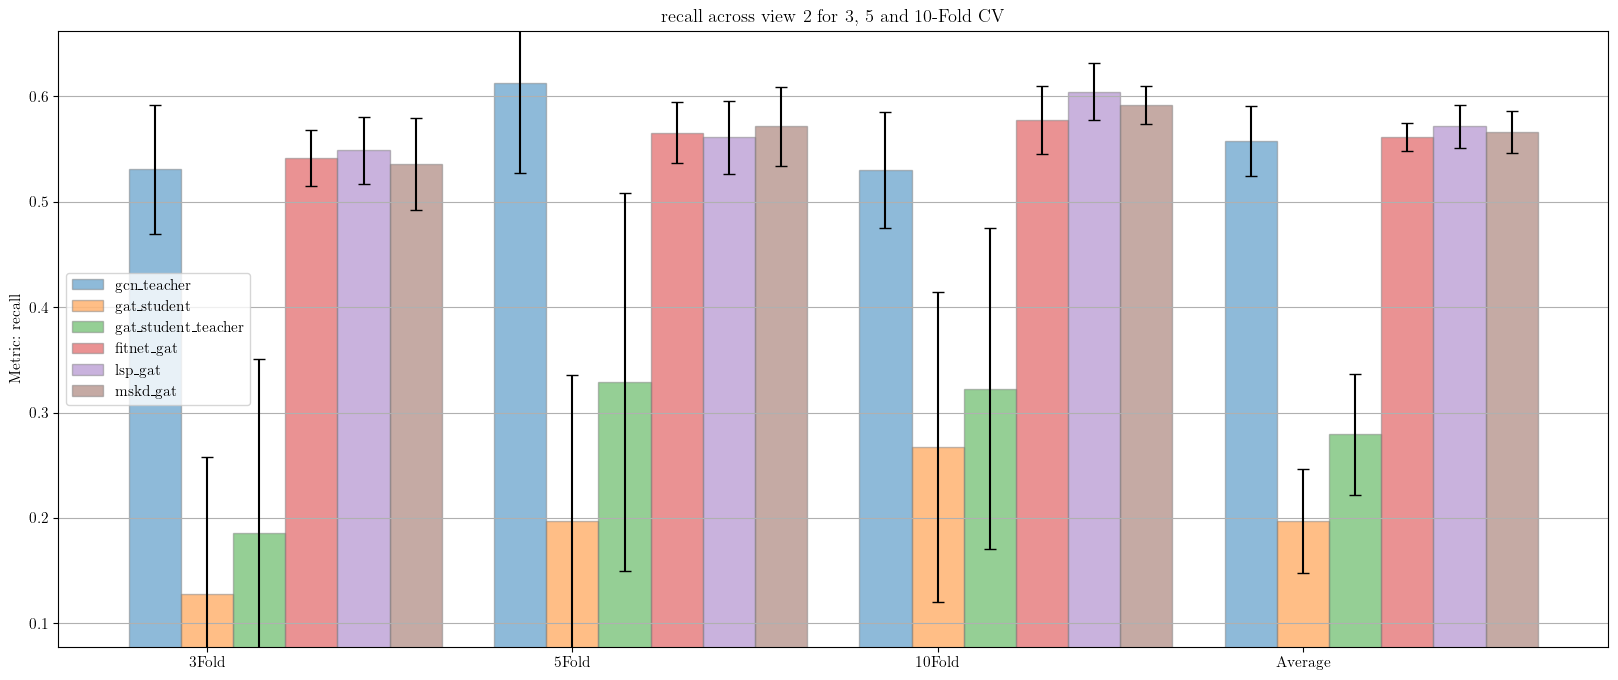

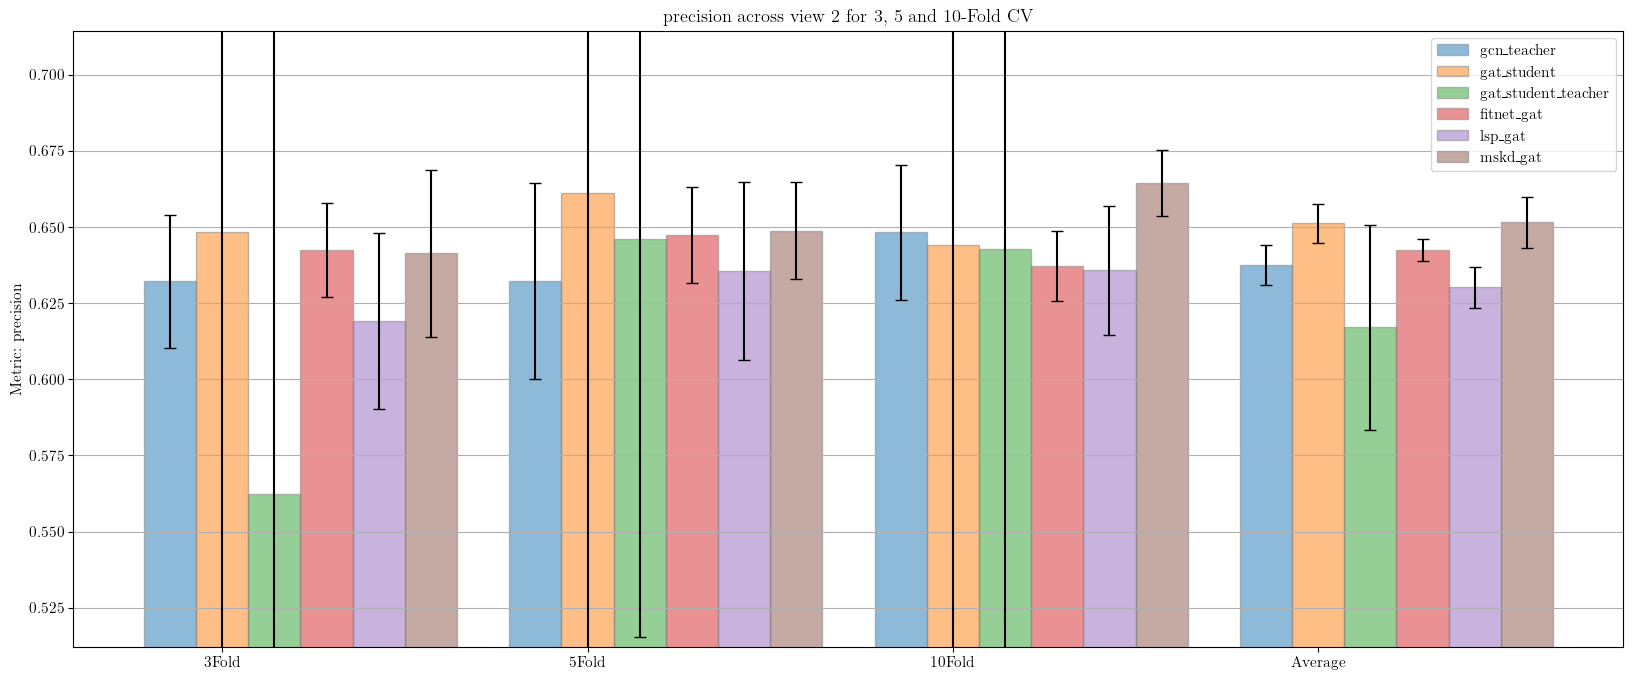

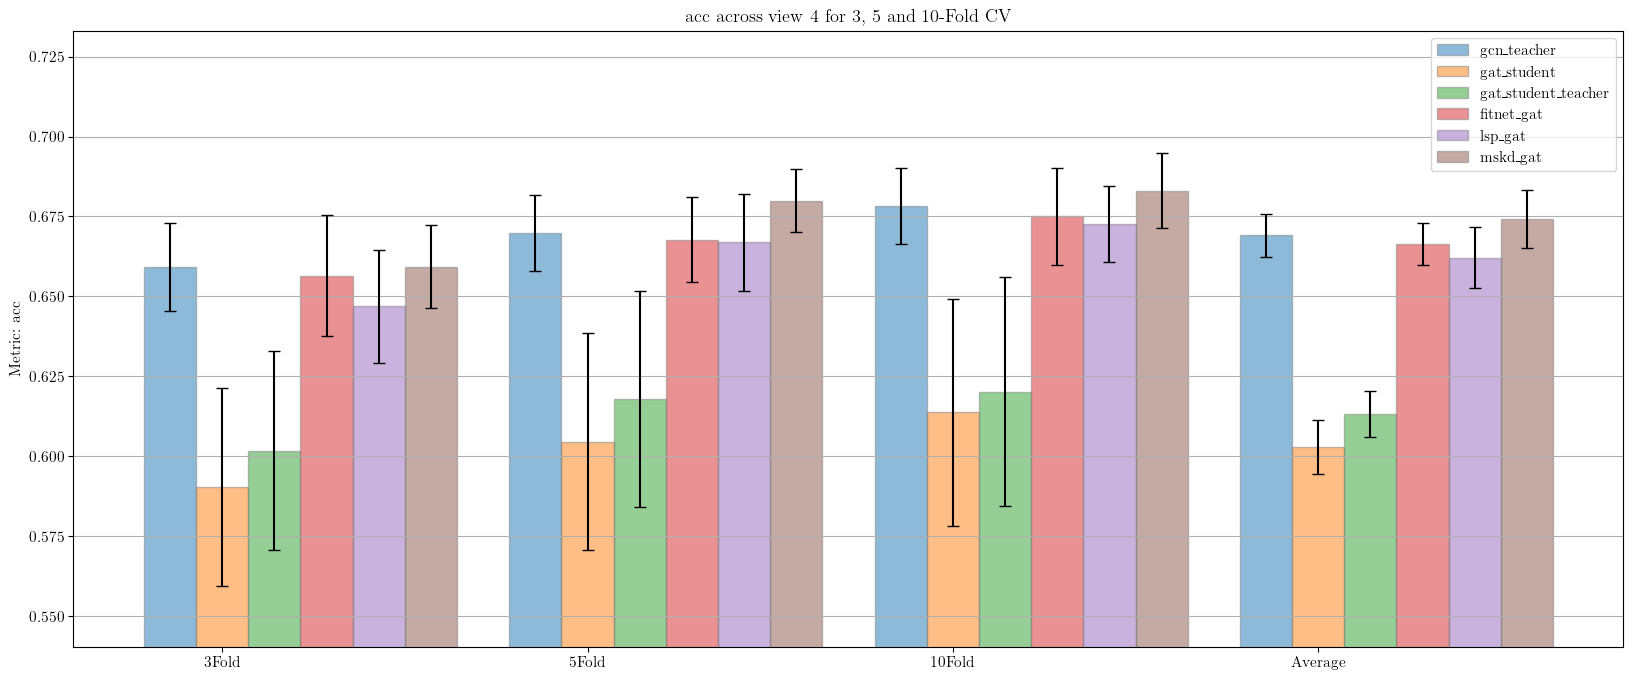

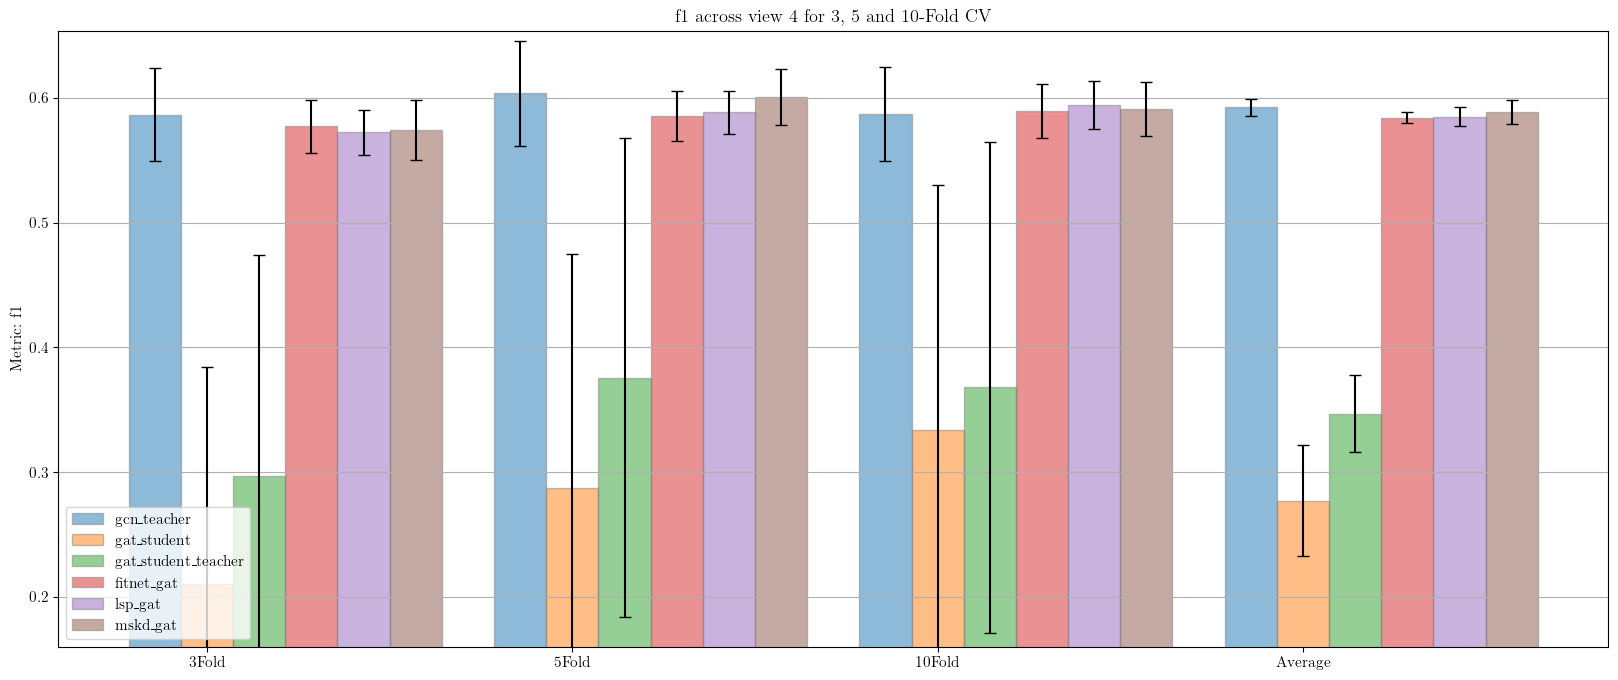

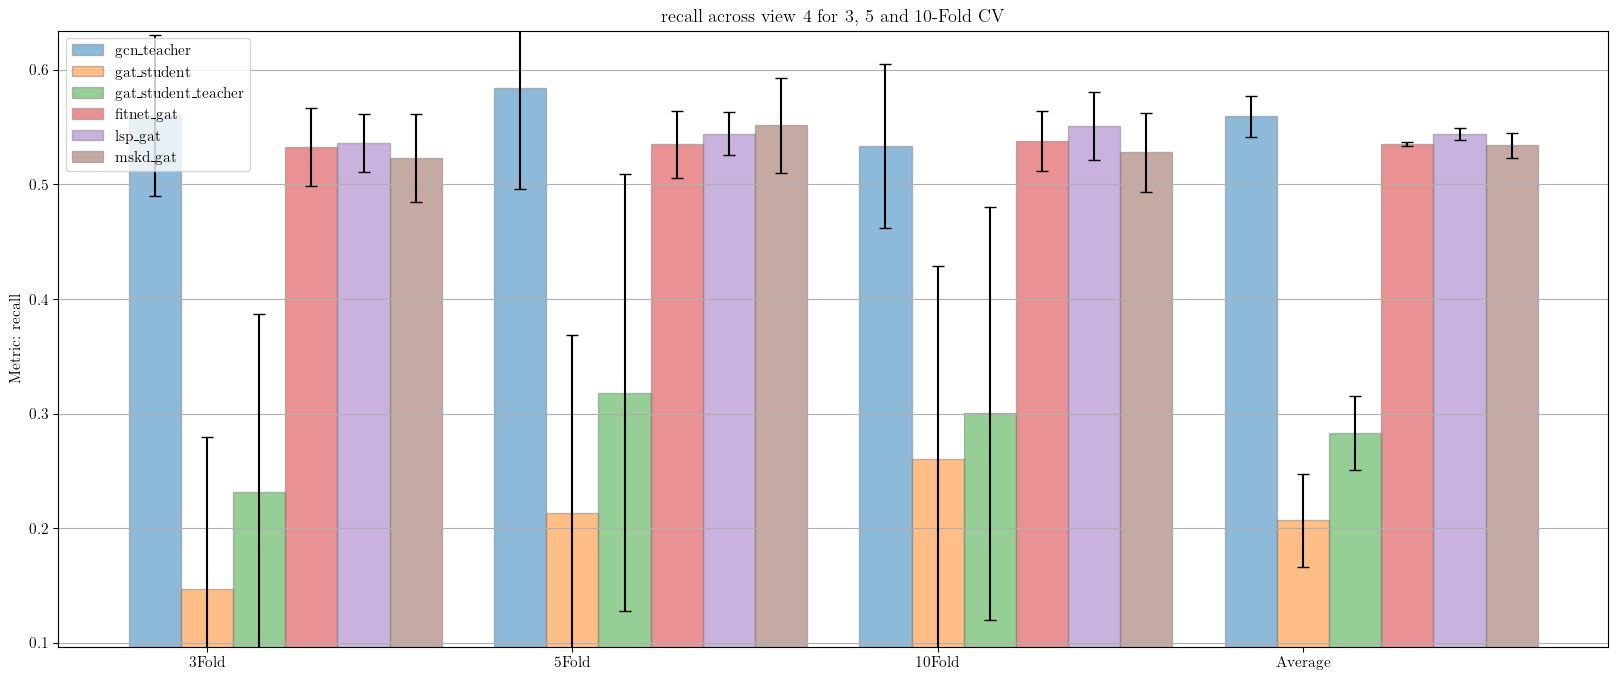

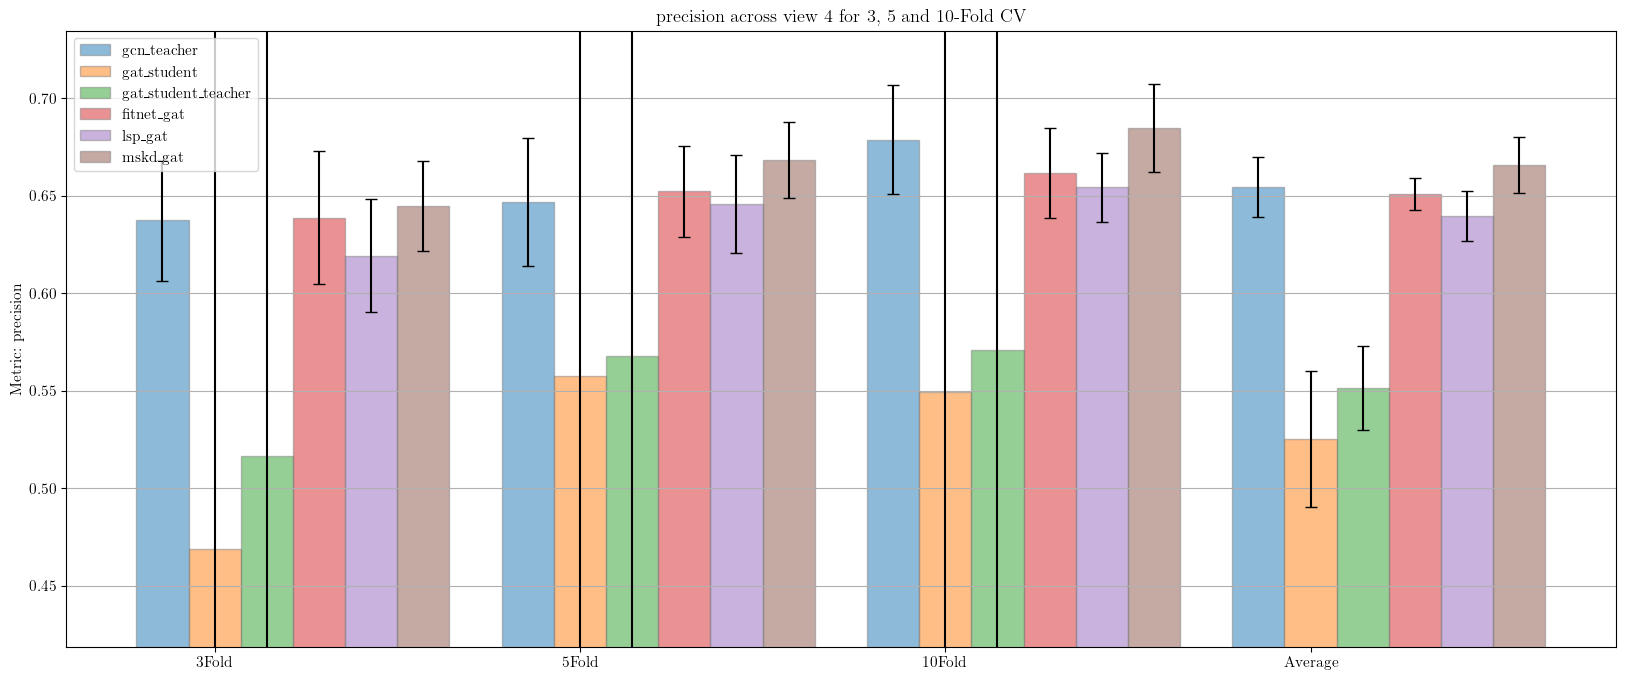

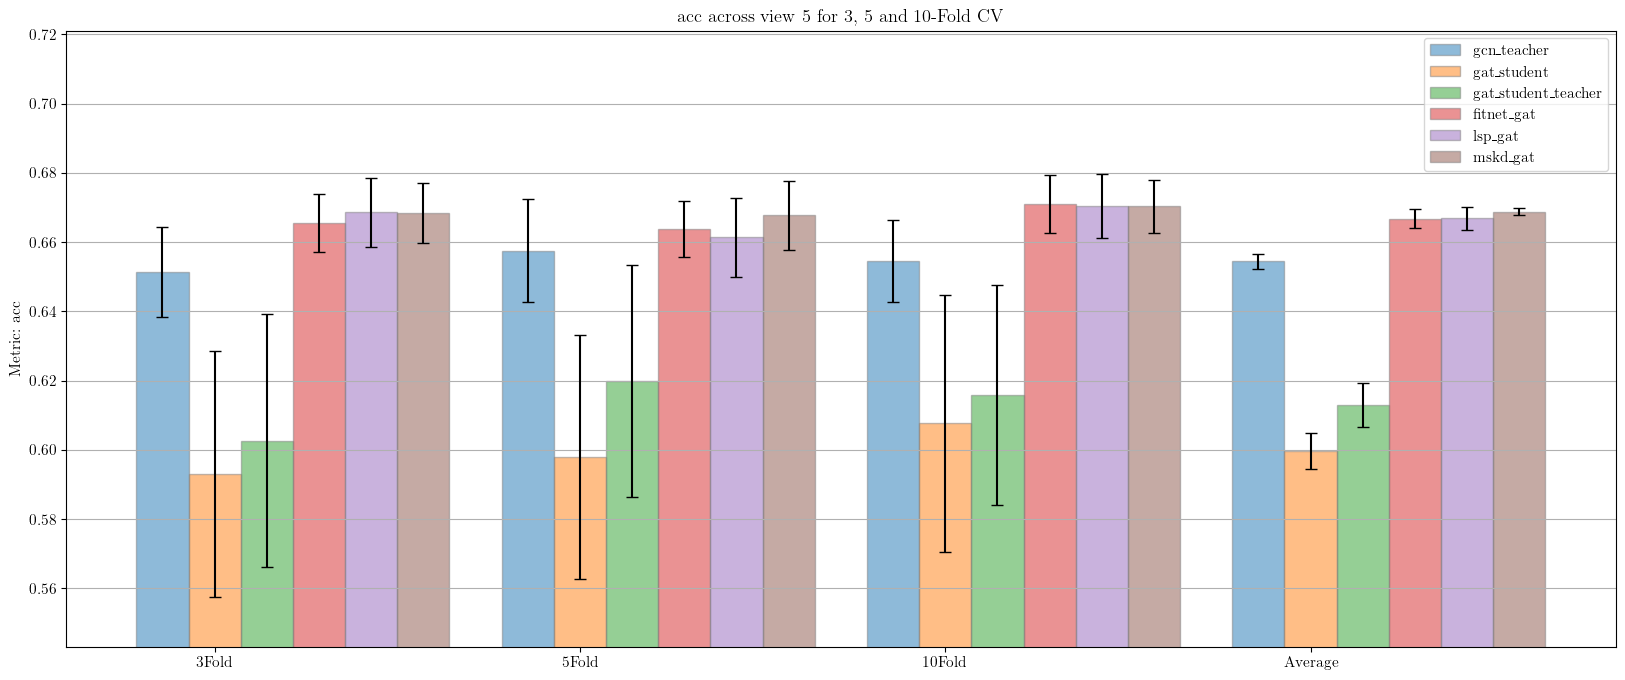

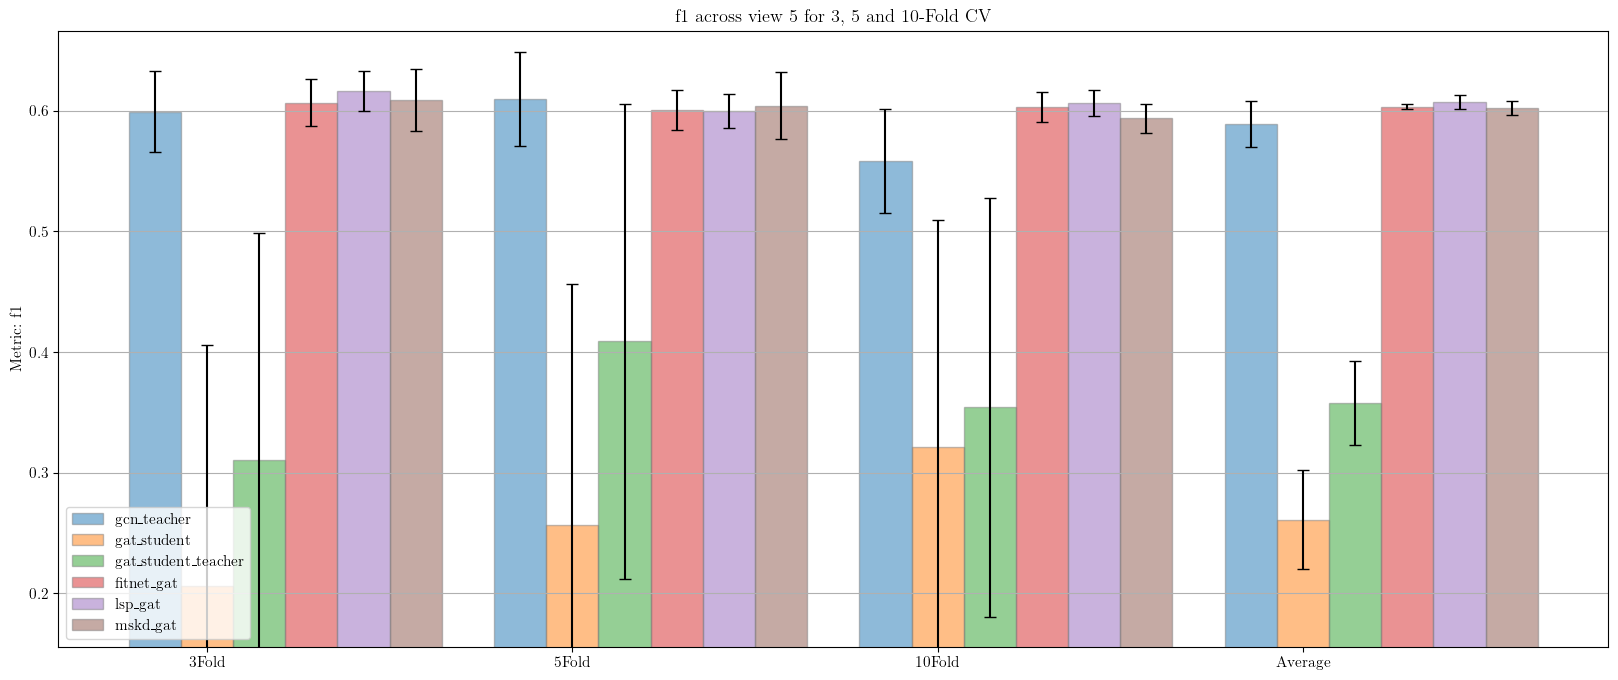

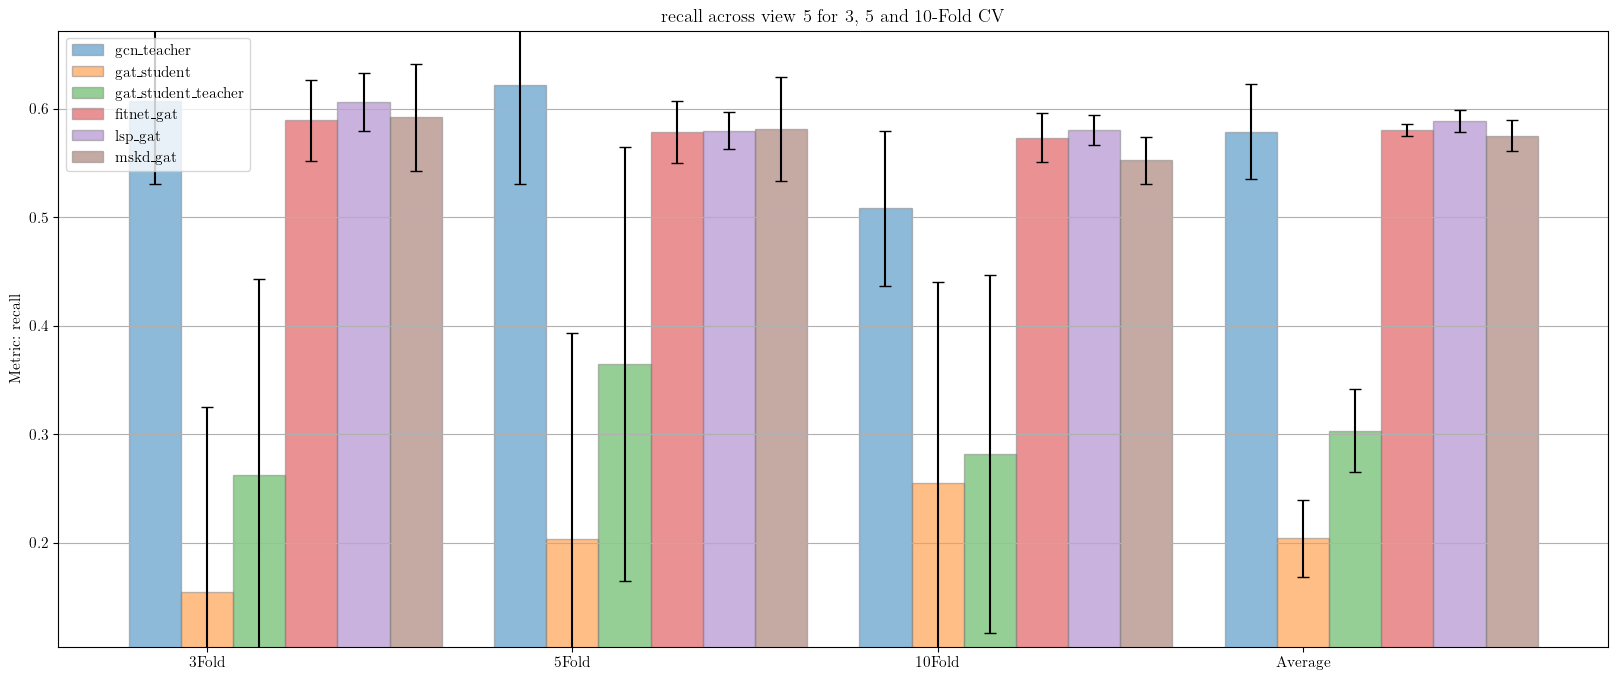

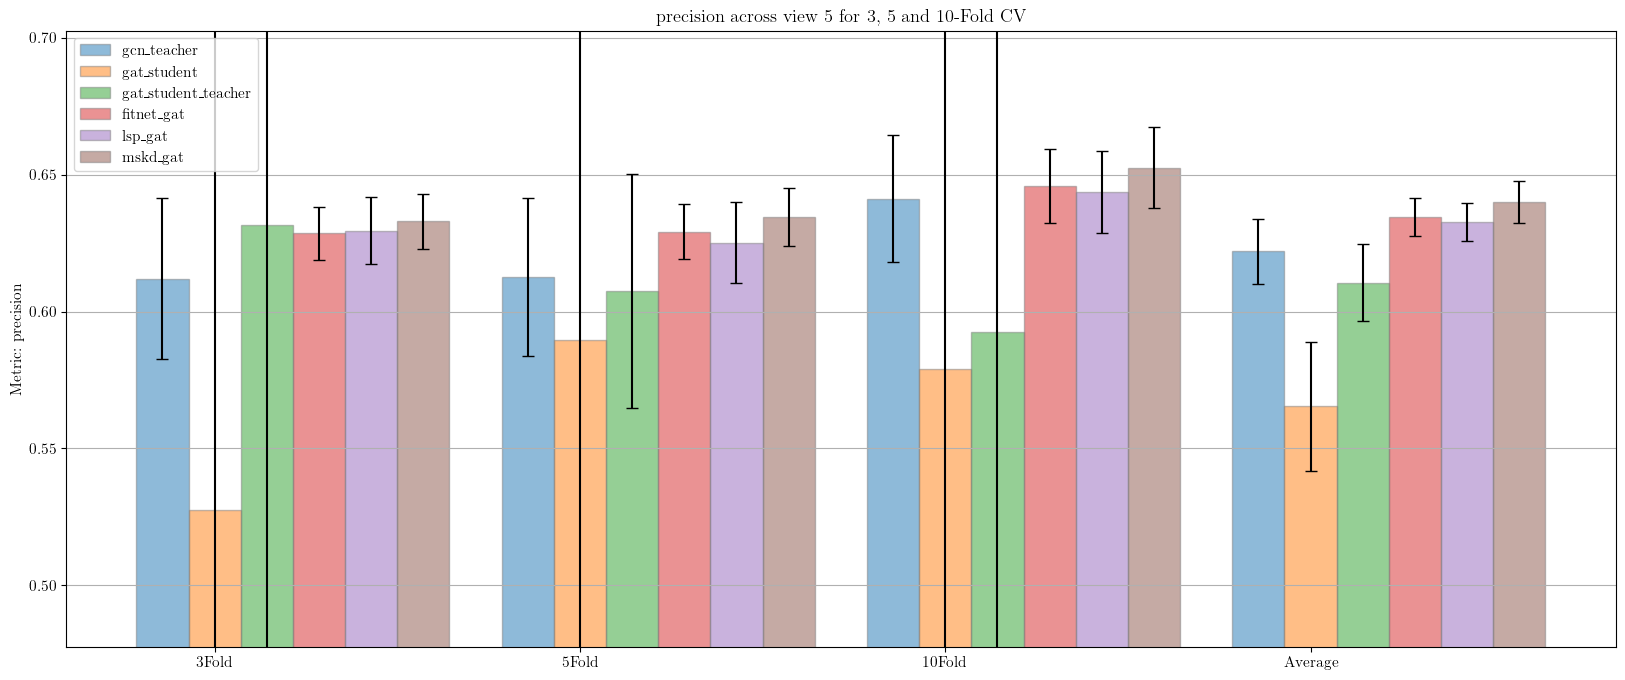

<Figure size 2000x800 with 0 Axes>

In [44]:
for view in [0,2,4,5]:
    plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(10)], metric="acc", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(10)], metric="f1", model_args=model_args,dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(10)], metric="recall", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(10)], metric="precision", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)

In [45]:
def get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    #EACH FOLD INDIVIDUAL

    student_data_mean = [] 
    student_data_var = [] 
    
    for student in range(model_args["n_students"]):

        run_data = []   

        for run in runs:

            model_metrics = []
            
            for training_type in CV:

                model_cv_metrics = get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                    )
                model_metrics.append(model_cv_metrics)
            
            run_data.append(model_metrics)
        
        student_data_mean.append(np.mean(run_data, axis=0))   
        student_data_var.append(np.std(run_data, axis=0))        

    return student_data_mean, student_data_var

In [46]:
def get_best_student_ensamble_detailed(model, view, CV, runs, dataset, dataset_split, analysis_type, model_args):
    import warnings
    warnings.filterwarnings('ignore')
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, all_student_metrics_var = get_student_model_metric_all_folds(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    
    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max accuracy
    best_max_acc = 0
    metric = 0
    student_max_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if student_acc > metric:
            metric = student_acc
            best_max_acc = rep
            student_max_acc_index = i

    #get the best model based on max reproducibility and f1 score
    best_max_f1 = 0
    metric = 0
    student_max_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if student_f1 > metric:
            metric = student_f1
            best_max_f1 = rep
            student_max_f1_index = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return all_student_metrics_mean, all_student_metrics_var, [[best_rep_max, student_var[student_max], student_max], [best_max_acc, student_var[student_max_acc_index], student_max_acc_index], [best_max_f1, student_var[student_max_f1_index], student_max_f1_index], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]]
    

In [47]:
def get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    """
    USAGE:
    runs = [i for i in range(10)]
    CV=["3Fold", "5Fold", "10Fold"]
    model = "gcn_student_ensamble_3"
    analysis_type="model_assessment"
    model_args= gcn_student_ensamble_args
    dataset_split="val"
    view=2

    get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    """

    all_student_metrics_mean = []
    all_student_metrics_var = []

    for student in range(model_args["n_students"]):

        model_metrics_runs = []
        
        for run in runs:
                
            model_metrics = []
            
            for training_type in CV:
                
                model_metrics.append(get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                )
                )
            
            model_metrics = np.mean(model_metrics, axis=0)
            model_metrics_runs.append(model_metrics)
        all_student_metrics_var.append(np.var(model_metrics_runs, axis=0))
        all_student_metrics_mean.append(np.mean(model_metrics_runs, axis=0))

    return all_student_metrics_mean, all_student_metrics_var


In [48]:
def view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=[0], model_args=None):
    """
    Reproducibility analysis for a single run for specific students in ensamble 
    student length = number of views, it is the specific student for each view
    """

    view_data_mean = []
    view_data_std = []

    for i, view in enumerate(views):
        
        model_result_mean = []
        model_result_std = []
        ensamble_count = 0

        for j, model in enumerate(models):

            rep_score, std = view_specific_rep(dataset=dataset, view=view, model=model, run=run, CV=CV, student=students[ensamble_count][i], model_args=model_args[j])
            model_result_mean.append(rep_score)
            model_result_std.append(std)
            
            if "ensamble" in models:
                ensamble_count += 1

        view_data_mean.append(model_result_mean)
        view_data_std.append(model_result_std)

    view_data_std.append(list(np.std(view_data_mean, axis=0)))
    view_data_std = np.array(view_data_std).T

    view_data_mean.append(list(np.mean(view_data_mean, axis=0)))

    view_data_mean = np.array(view_data_mean).T
    
    return view_data_mean, view_data_std 

In [49]:
def reproducibility_mulitple_runs_student_specific(dataset, views, models, CV, runs, students=0, model_args=None):

    mean_all_runs = []
    runs=runs
    for run in runs:
        view_data_mean, _ = view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=students, model_args=model_args)
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0)
    mean_all_runs = np.mean(mean_all_runs, axis=0)
    
    return mean_all_runs, mean_all_std

In [50]:
def get_mean_CV_metric_student_model(dataset, model, analysis_type, training_type, view, run, student, dataset_split, model_args):

    import sklearn.metrics as metrics

    #get the mean metric for a student for a particular CV training_type 
    
    student_acc, student_recall, student_precision, student_f1 = 0, 0, 0, 0
    acc_mean, recall_mean, precision_mean, f1_mean = [], [], [], []
    
    if training_type == "3Fold":
        cv_number = 3
    if training_type == "5Fold":
        cv_number = 5
    if training_type == "10Fold":
        cv_number = 10  
    
    for i in range(cv_number):
        x = get_labels_and_preds(dataset=dataset, 
                                model=model,
                                analysis_type=analysis_type, 
                                training_type=training_type,  
                                cv_n=i, 
                                view=view, 
                                run=run, 
                                dataset_split=dataset_split, 
                                student=student, 
                                model_args=model_args)
        result = {
            'prec': metrics.precision_score(x['labels'],  x['preds']),
            'recall': metrics.recall_score(x['labels'],  x['preds']),
            'acc': metrics.accuracy_score(x['labels'],  x['preds']),
            'F1': metrics.f1_score(x['labels'],  x['preds'])
        }   
        acc_mean.append(result['acc'])
        recall_mean.append(result['recall'])
        precision_mean.append(result['prec'])
        f1_mean.append(result['F1'])
    
    student_acc = np.mean(acc_mean)
    student_recall = np.mean(recall_mean)
    student_precision = np.mean(precision_mean)
    student_f1 = np.mean(f1_mean)

    return student_acc, student_f1, student_recall, student_precision

In [51]:
analysis_type="model_assessment"
dataset_split="val"
dataset="gender_data"
models_args=[
    gcn_gat_student_lsp_ensamble_2_args,
    gcn_gat_student_lsp_ensamble_3_args,
    gcn_gat_student_lsp_ensamble_4_args,
    gcn_gat_student_lsp_ensamble_5_args
]

all_model_metrics_mean = []
all_model_metrics_var = []
all_model_best_student = []

for model_arg in models_args:
    
    print(model_arg["model_name"])

    model_metrics_mean = []
    model_metrics_var = []
    model_best_student = []

    for view in [0,2,4,5]:
        mean, var, best_students = get_best_student_ensamble_detailed(
            model=model_arg["model_name"], 
            view=view, 
            CV=["3Fold", "5Fold", "10Fold"],
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            dataset=dataset,
            model_args=model_arg
        )
        print(best_students)
        model_metrics_mean.append(mean)
        model_metrics_var.append(var)
        model_best_student.append(best_students)

    all_model_metrics_mean.append(model_metrics_mean)
    all_model_metrics_var.append(model_metrics_var)
    all_model_best_student.append(model_best_student)

gat_student_lsp_ensamble_2
[[0.9511111111111109, 0.0007472222222222231, 0], [0.9299999999999999, 0.0006420524691358031, 1], [0.9299999999999999, 0.0006420524691358031, 1], [0.9511111111111109, 0.0007472222222222231, 0], [0.9299999999999999, 0.0006420524691358031, 1]]
[[0.9297222222222222, 0.0003307098765432091, 1], [0.9297222222222222, 0.0003307098765432091, 1], [0.9297222222222222, 0.0003307098765432091, 1], [0.9297222222222222, 0.0003307098765432091, 1], [0.9297222222222222, 0.0003307098765432091, 1]]
[[0.9306944444444445, 0.0007277970679012331, 0], [0.89375, 0.002746238425925927, 1], [0.89375, 0.002746238425925927, 1], [0.9306944444444445, 0.0007277970679012331, 0], [0.89375, 0.002746238425925927, 1]]
[[0.9402777777777779, 0.00013001543209876625, 0], [0.8708333333333332, 0.0007773919753086436, 1], [0.8708333333333332, 0.0007773919753086436, 1], [0.9402777777777779, 0.00013001543209876625, 0], [0.9402777777777779, 0.00013001543209876625, 0]]
gat_student_lsp_ensamble_3
[[0.95972222222

In [52]:
df_best_student = np.array(all_model_best_student)
df = []
for i in range(4):
    df.append(df_best_student[:, i, :, 0].flatten())
df = pd.DataFrame(np.array(df))
# Calculate the mean of columns
mean_row = df.mean(axis=0)

# Append the mean row to the DataFrame
df = df.append(mean_row, ignore_index=True).T
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df) % 5]

# Assign the new index to the DataFrame
df.index = index_values
df.shape

(20, 5)

In [53]:
index = df_best_student[:,:,:,2]
all_data_accuracy = []
for view_index in range(4):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_mean)[:,view_index]
    #number of ensembles 
    for i in range(4):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_accuracy.append(np.array(view_data).flatten())

In [54]:
all_data_var = []
for view_index in range(4):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_var)[:,view_index]
    #number of ensembles 
    for i in range(4):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_var.append(np.array(view_data).flatten())

In [55]:
df_acuracy = pd.DataFrame(np.array(all_data_accuracy))
# Calculate the mean of columns
mean_row = df_acuracy.mean(axis=0)

# Append the mean row to the DataFrame
df_acuracy = df_acuracy.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_acuracy) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_acuracy) % 5]

# Assign the new index to the DataFrame
df_acuracy.index = index_values
df_acuracy.shape

(20, 5)

In [56]:
df_var = pd.DataFrame(np.array(all_data_var))
# Calculate the mean of columns
mean_row = df_var.mean(axis=0)

# Append the mean row to the DataFrame
df_var = df_var.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_var) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_var) % 5]

# Assign the new index to the DataFrame
df_var.index = index_values
df_var.shape

(20, 5)

In [57]:
df_acuracy = df_acuracy.loc['weighted acc'].T
df_var = df_var.loc['weighted acc'].T
df_var = np.sqrt(df_var)

In [58]:
import pandas as pd
# Define the new column labels
new_labels = ['2 w/ LSP', '3 w/ LSP', '4 w/ LSP',  '5 w/ LSP']
df_rep = df.loc['weighted acc'].T

# Rename the columns using the new labels
df_rep.columns = new_labels
df_acuracy.columns = new_labels
df_var.columns = new_labels
df_rep, df_acuracy



(   2 w/ LSP  3 w/ LSP  4 w/ LSP  5 w/ LSP
 0  0.951111  0.959722  0.977778  0.975278
 1  0.929722  0.957500  0.985833  0.966667
 2  0.930694  0.956806  0.983889  0.985139
 3  0.940278  0.915139  0.962917  0.963333
 4  0.937951  0.947292  0.977604  0.972604,
    2 w/ LSP  3 w/ LSP  4 w/ LSP  5 w/ LSP
 0  0.560143  0.567746  0.562525  0.560018
 1  0.643249  0.562680  0.574510  0.581532
 2  0.560622  0.560961  0.559756  0.557949
 3  0.560575  0.602495  0.560663  0.578375
 4  0.581147  0.573470  0.564364  0.569469)

In [119]:
mean_all_runs, mean_all_std = reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0,2,4,5], 
    models=["gcn", "gat_student", "gat_student_teacher", "fitnet_gat",  "lsp_gat", "mskd_gat", "gat_student_lsp_ensamble_2"],
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[
        [0,1,0,0]
    ], 
    model_args = [gcn_args, 
                  gat_gat_student_args, 
                  gcn_gat_student_args, 
                  gcn_gat_fitnet_student_args, 
                  gcn_gat_lsp_student_args,
                  gcn_gat_mskd_student_args,
                  gcn_gat_student_lsp_ensamble_2_args])

In [120]:
reproducibility_frame = pd.DataFrame(mean_all_runs.T)

models=["gcn", "gat_student", "gat_student_teacher", "fitnet_gat",  "lsp_gat", "mskd_gat", "gat_student_lsp_ensamble_2"]
reproducibility_frame.columns = models

reproducibility_frame["delta teacher"] = ((reproducibility_frame["gat_student_lsp_ensamble_2"] - reproducibility_frame["gcn"]) / reproducibility_frame["gcn"])*100
reproducibility_frame["delta student"] = ((reproducibility_frame["gat_student_lsp_ensamble_2"] - reproducibility_frame["gat_student"]) / reproducibility_frame["gat_student"])*100
reproducibility_frame["delta vanilla"] = ((reproducibility_frame["gat_student_lsp_ensamble_2"] - reproducibility_frame["gat_student_teacher"]) / reproducibility_frame["gat_student_teacher"])*100
reproducibility_frame["delta fitnet"] = ((reproducibility_frame["gat_student_lsp_ensamble_2"] - reproducibility_frame["fitnet_gat"]) / reproducibility_frame["fitnet_gat"])*100
reproducibility_frame["delta lsp"] = ((reproducibility_frame["gat_student_lsp_ensamble_2"] - reproducibility_frame["lsp_gat"]) / reproducibility_frame["lsp_gat"])*100
reproducibility_frame["delta mskd"] = ((reproducibility_frame["gat_student_lsp_ensamble_2"] - reproducibility_frame["mskd_gat"]) / reproducibility_frame["mskd_gat"])*100

In [104]:
reproducibility_frame.T

,0,1,2,3,4
gcn,0.891389,0.888750,0.905972,0.901667,0.896944
gat_student,0.919444,0.907361,0.919861,0.917500,0.916042
gat_student_teacher,0.894861,0.846250,0.867639,0.884028,0.873194
fitnet_gat,0.743611,0.790278,0.737500,0.768333,0.759931
lsp_gat,0.888472,0.852917,0.825694,0.876250,0.860833
mskd_gat,0.844722,0.830556,0.853056,0.836667,0.841250
gat_student_lsp_ensamble_2,0.951111,0.929722,0.930694,0.940278,0.937951
delta teacher,6.699907,4.610095,2.728806,4.282193,4.571849
delta student,3.444109,2.464411,1.177714,2.482592,2.391782
delta vanilla,6.285892,9.863778,7.267488,6.362922,7.416097


In [117]:
reproducibility_frame.T*100

,0,1,2,3,4
gcn,89.138889,88.875000,90.597222,90.166667,89.694444
gat_student,91.944444,90.736111,91.986111,91.750000,91.604167
gat_student_teacher,89.486111,84.625000,86.763889,88.402778,87.319444
fitnet_gat,74.361111,79.027778,73.750000,76.833333,75.993056
lsp_gat,88.847222,85.291667,82.569444,87.625000,86.083333
mskd_gat,84.472222,83.055556,85.305556,83.666667,84.125000
gat_student_lsp_ensamble_2,95.111111,92.972222,93.069444,94.027778,93.795139
delta teacher,669.990651,461.009533,272.880576,428.219347,457.184887
delta student,344.410876,246.441145,117.771403,248.259158,239.178228
delta vanilla,628.589167,986.377811,726.748839,636.292223,741.609671


In [121]:
reproducibility_frame_std = pd.DataFrame(mean_all_std.T)
reproducibility_frame_std.T*100

,0,1,2,3,4
0,3.737531,3.388120,4.468274,5.456336,3.138927
1,3.333912,4.073045,3.429206,3.744955,0.864548
2,4.881327,9.628126,9.476874,6.575843,3.195644
3,10.086088,13.025823,12.555740,12.617473,7.037676
4,5.828387,5.402921,7.954163,6.080558,3.754171
5,9.772055,6.949443,4.778182,4.825345,5.402198
6,2.733537,1.818543,2.697771,1.140243,1.333989


In [180]:
views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
#model = ["gcn_student_ensamble_4", "gcn_student_lsp_ensamble_4"]
model = ["gat_student_lsp_ensamble_2"]
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
#model_args= [gcn_student_ensamble_4_args, gcn_student_lsp_ensamble_4_args]
model_args= [gcn_gat_student_lsp_ensamble_2_args]

best_student = [0,1,0,0]

view_mean = []
view_std = []
    
for best_student_i, view in enumerate(views):

    models = ["gcn", "gat_student", "gat_student_teacher", "fitnet_gat",  "lsp_gat", "mskd_gat"]
    mean_all_runs = []
    for run in runs:
        view_data_mean, _ = view_metric_analysis(models=models, CV=CV, view=view, run=run, metric="acc", dataset=dataset, 
                                                 dataset_split=dataset_split, analysis_type=analysis_type, 
                                                 model_args= [
                                                    gcn_args, 
                                                    gat_gat_student_args,
                                                    gcn_gat_student_args,
                                                    gcn_gat_fitnet_student_args,
                                                    gcn_gat_lsp_student_args,
                                                    gcn_gat_mskd_student_args])
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    model_mean = []
    model_std = []

    for i, model_arg in enumerate(model_args):
        mean, std = get_student_model_metric(dataset, model[i], CV, runs, analysis_type, dataset_split, view, model_arg)
        model_mean.append(mean[index_student])
        model_std.append(std[index_student])
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
    

        mean_df = np.array(model_mean[0])[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(model_std[0])[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

    view_mean.append(np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)])
    view_std.append(np.c_[ final_var_df, np.std(final_var_df, axis=1)])

{'prec': 0.4523809523809524, 'recall': 0.18627450980392157, 'acc': 0.5431034482758621, 'F1': 0.26388888888888895}
{'prec': 0.5185185185185185, 'recall': 0.13725490196078433, 'acc': 0.5646551724137931, 'F1': 0.21705426356589144}
{'prec': 0.45, 'recall': 0.08737864077669903, 'acc': 0.5512820512820513, 'F1': 0.14634146341463417}
{'prec': 0.44, 'recall': 0.18032786885245902, 'acc': 0.539568345323741, 'F1': 0.2558139534883721}
{'prec': 0.625, 'recall': 0.16393442622950818, 'acc': 0.5899280575539568, 'F1': 0.2597402597402597}
{'prec': 0.375, 'recall': 0.09836065573770492, 'acc': 0.5323741007194245, 'F1': 0.15584415584415584}
{'prec': 0.4375, 'recall': 0.11475409836065574, 'acc': 0.5467625899280576, 'F1': 0.18181818181818182}
{'prec': 0.5, 'recall': 0.1111111111111111, 'acc': 0.5563380281690141, 'F1': 0.1818181818181818}
{'prec': 0.5555555555555556, 'recall': 0.3333333333333333, 'acc': 0.5942028985507246, 'F1': 0.4166666666666667}
{'prec': 0.2857142857142857, 'recall': 0.06666666666666667, 'a

In [181]:
average_across_views = []
for i in range(4):
    average_across_views.append(view_mean[i][:,-1])

In [185]:
average_across_views_df = pd.DataFrame(average_across_views)
# Assuming you have a DataFrame named 'df'
average_across_views_df_mean = average_across_views_df.mean(axis=0)  # Calculate the mean of each row
average_across_views_df_mean = pd.DataFrame(average_across_views_df_mean).T  # Create a DataFrame from the row means

# Append the row mean DataFrame to the original DataFrame
average_across_views_df = average_across_views_df.append(average_across_views_df_mean, ignore_index=True)

# Display the DataFrame with the added row
average_across_views_df

,0,1,2,3,4,5,6
0,0.610109,0.575247,0.577661,0.634690,0.634340,0.637955,0.553303
1,0.661582,0.611658,0.625019,0.668718,0.662723,0.674634,0.633326
2,0.669069,0.602900,0.613245,0.666416,0.662139,0.674120,0.623882
3,0.654419,0.599624,0.612828,0.666809,0.666841,0.668822,0.607022
4,0.648795,0.597357,0.607188,0.659158,0.656511,0.663883,0.604383


In [186]:
average_across_views_df = pd.DataFrame(average_across_views_df)
models=["gcn", "gat_student", "gat_student_teacher", "fitnet_gat",  "lsp_gat", "mskd_gat", "gat_student_lsp_ensamble_2"]

average_across_views_df.columns = models

average_across_views_df["delta teacher"] = ((average_across_views_df["gat_student_lsp_ensamble_2"] - average_across_views_df["gcn"]) / average_across_views_df["gcn"])*100
average_across_views_df["delta student"] = ((average_across_views_df["gat_student_lsp_ensamble_2"] - average_across_views_df["gat_student"]) / average_across_views_df["gat_student"])*100

average_across_views_df["delta vanilla"] = ((average_across_views_df["gat_student_lsp_ensamble_2"] - average_across_views_df["gat_student_teacher"]) / average_across_views_df["gat_student_teacher"])*100
average_across_views_df["delta fitnet"] = ((average_across_views_df["gat_student_lsp_ensamble_2"] - average_across_views_df["fitnet_gat"]) / average_across_views_df["fitnet_gat"])*100
average_across_views_df["delta lsp"] = ((average_across_views_df["gat_student_lsp_ensamble_2"] - average_across_views_df["lsp_gat"]) / average_across_views_df["lsp_gat"])*100
average_across_views_df["delta mskd"] = ((average_across_views_df["gat_student_lsp_ensamble_2"] - average_across_views_df["mskd_gat"]) / average_across_views_df["mskd_gat"])*100

In [187]:
average_across_views_df.T

,0,1,2,3,4
gcn,0.610109,0.661582,0.669069,0.654419,0.648795
gat_student,0.575247,0.611658,0.602900,0.599624,0.597357
gat_student_teacher,0.577661,0.625019,0.613245,0.612828,0.607188
fitnet_gat,0.634690,0.668718,0.666416,0.666809,0.659158
lsp_gat,0.634340,0.662723,0.662139,0.666841,0.656511
mskd_gat,0.637955,0.674634,0.674120,0.668822,0.663883
gat_student_lsp_ensamble_2,0.553303,0.633326,0.623882,0.607022,0.604383
delta teacher,-9.310756,-4.270969,-6.753733,-7.242608,-6.845226
delta student,-3.814613,3.542439,3.480240,1.233799,1.176210
delta vanilla,-4.216613,1.329091,1.734511,-0.947433,-0.461965


In [184]:
average_across_views_df.T

,0,1,2,3,4
0,0.610109,0.661582,0.669069,0.654419,0.648795
1,0.575247,0.611658,0.602900,0.599624,0.597357
2,0.577661,0.625019,0.613245,0.612828,0.607188
3,0.634690,0.668718,0.666416,0.666809,0.659158
4,0.634340,0.662723,0.662139,0.666841,0.656511
5,0.637955,0.674634,0.674120,0.668822,0.663883
6,0.553303,0.633326,0.623882,0.607022,0.604383


In [134]:
average_across_views_std = []
for i in range(4):
    average_across_views_std.append(view_std[i][:,-1])

In [135]:
average_across_views_df = pd.DataFrame(average_across_views_std)
# Assuming you have a DataFrame named 'df'
average_across_views_df_mean = average_across_views_df.mean(axis=0)  # Calculate the mean of each row
average_across_views_df_mean = pd.DataFrame(average_across_views_df_mean).T  # Create a DataFrame from the row means

# Append the row mean DataFrame to the original DataFrame
average_across_views_df = average_across_views_df.append(average_across_views_df_mean, ignore_index=True)

# Display the DataFrame with the added row
average_across_views_df.T*100

,0,1,2,3,4
0,0.297329,0.092750,0.087278,0.124343,0.150425
1,0.488970,0.067514,0.194284,0.084351,0.208780
2,0.406445,0.082362,0.192720,0.201756,0.220821
3,0.202227,0.040721,0.239071,0.017872,0.124973
4,0.277649,0.193243,0.234845,0.084801,0.197634
5,0.224388,0.458781,0.132597,0.098847,0.228653
6,0.081394,0.369610,0.133377,0.078644,0.165756


In [177]:
views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
model = ["gcn_student_lsp_ensamble_2"]
runs = [0,1,2,3,4,5,6,8,9]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["f1"]
model_args= [gat_student_lsp_ensamble_2_args]

best_student = [0,1,0,0]
#best_student_4_lsp = [2,1,2,1]

view_mean = []
view_std = []
    
for best_student_i, view in enumerate(views):

    models = ["gcn", "gat_student", "gat_student_teacher", "fitnet_gat",  "lsp_gat", "mskd_gat"]
    mean_all_runs = []
    for run in [0,1,2,3,4,5,6,8,9]:
        view_data_mean, _ = view_metric_analysis(models=models, CV=CV, view=view, run=run, metric="f1", dataset=dataset, 
                                                 dataset_split=dataset_split, analysis_type=analysis_type, 
                                                 model_args= [
                                                    gcn_args, 
                                                    gat_gat_student_args,
                                                    gcn_gat_student_args,
                                                    gcn_gat_fitnet_student_args,
                                                    gcn_gat_lsp_student_args,
                                                    gcn_gat_mskd_student_args
                                                ]
                                            )
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    model_mean = []
    model_std = []

    for i, model_arg in enumerate(model_args):
        mean, std = get_student_model_metric(dataset, model[i], CV, runs, analysis_type, dataset_split, view, model_arg)
        model_mean.append(mean[index_student])
        model_std.append(std[index_student])
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
    

        mean_df = np.array(model_mean[0])[:,1]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(model_std[0])[:,1]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

    view_mean.append(np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)])
    view_std.append(np.c_[ final_var_df, np.std(final_var_df, axis=1)])

{'prec': 0.4523809523809524, 'recall': 0.18627450980392157, 'acc': 0.5431034482758621, 'F1': 0.26388888888888895}
{'prec': 0.5185185185185185, 'recall': 0.13725490196078433, 'acc': 0.5646551724137931, 'F1': 0.21705426356589144}
{'prec': 0.45, 'recall': 0.08737864077669903, 'acc': 0.5512820512820513, 'F1': 0.14634146341463417}
{'prec': 0.44, 'recall': 0.18032786885245902, 'acc': 0.539568345323741, 'F1': 0.2558139534883721}
{'prec': 0.625, 'recall': 0.16393442622950818, 'acc': 0.5899280575539568, 'F1': 0.2597402597402597}
{'prec': 0.375, 'recall': 0.09836065573770492, 'acc': 0.5323741007194245, 'F1': 0.15584415584415584}
{'prec': 0.4375, 'recall': 0.11475409836065574, 'acc': 0.5467625899280576, 'F1': 0.18181818181818182}
{'prec': 0.5, 'recall': 0.1111111111111111, 'acc': 0.5563380281690141, 'F1': 0.1818181818181818}
{'prec': 0.5555555555555556, 'recall': 0.3333333333333333, 'acc': 0.5942028985507246, 'F1': 0.4166666666666667}
{'prec': 0.2857142857142857, 'recall': 0.06666666666666667, 'a

In [178]:
average_across_views = []
for i in range(4):
    average_across_views.append(view_mean[i][:,-1])

In [179]:
average_across_views_df = pd.DataFrame(average_across_views)
# Assuming you have a DataFrame named 'df'
average_across_views_df_mean = average_across_views_df.mean(axis=0)  # Calculate the mean of each row
average_across_views_df_mean = pd.DataFrame(average_across_views_df_mean).T  # Create a DataFrame from the row means

# Append the row mean DataFrame to the original DataFrame
average_across_views_df = average_across_views_df.append(average_across_views_df_mean, ignore_index=True)

# Display the DataFrame with the added row
average_across_views_df

,0,1,2,3,4,5,6
0,0.519277,0.145368,0.194889,0.548069,0.557712,0.549331,0.213052
1,0.590438,0.282774,0.365385,0.595525,0.601752,0.604536,0.568838
2,0.597402,0.265936,0.346516,0.586056,0.584346,0.589344,0.529003
3,0.591620,0.280981,0.381629,0.603375,0.607327,0.602458,0.362411
4,0.574684,0.243765,0.322105,0.583256,0.587784,0.586417,0.418326


In [ ]:
#gat_student_lsp_ensamble_2_args -> gcn_gat_student_lsp_ensamble_2_args